In [526]:
import nltk
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\biraaj\AppData\Roaming\nltk_data...


In [450]:
## Libraries to import
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

In [451]:
main_dataset = pd.read_csv('train_data.csv')
main_dataset.head()

,Unnamed: 0,Sentence_id,New_Sentence,Type
0,0,GERRES15609,Author and/or Review architecture/design and o...,Responsibility
1,1,PHERES15784,Should be able to develop custom dynamic shape...,Responsibility
2,2,GERREQ10457,Experience in working crosslly with a larger ...,Requirement
3,3,GERSKL27235,"Previous business experience, including but no...",Skill
4,4,HONSSK18415,Delivering fast and right the first time.,SoftSkill


In [452]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60115 entries, 0 to 60114
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    60115 non-null  int64 
 1   Sentence_id   60115 non-null  object
 2   New_Sentence  59002 non-null  object
 3   Type          60115 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [453]:
count_of_words = main_dataset.Type.value_counts()
print(count_of_words)

Responsibility    15561
Requirement       14132
SoftSkill          9581
Experience         9248
Skill              6956
Education          4637
Name: Type, dtype: int64


In [454]:
# There are 6 classes as per above Information
class_list = ["Responsibility","Requirement","SoftSkill","Experience","Skill","Education"]

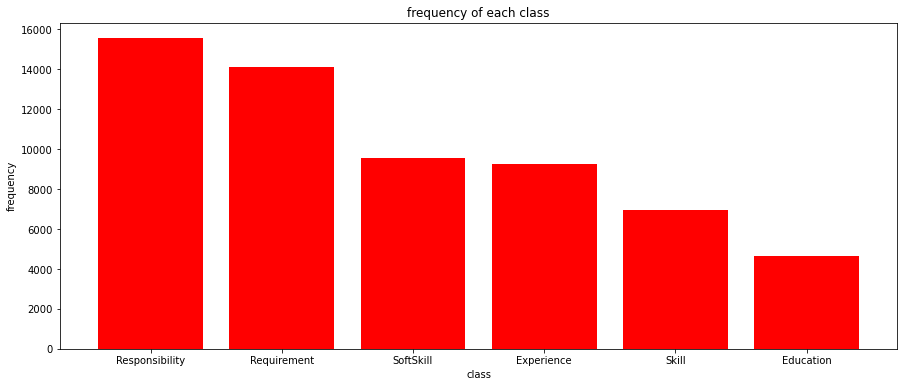

In [455]:
# Plotting the values in each classes
plt.figure(figsize=(15,6))
plt.bar(class_list,count_of_words,color="red")
plt.xlabel('class')
plt.ylabel('frequency')
plt.title('frequency of each class')
plt.show()

In [456]:
main_dataset["New_Sentence"].isnull().sum()

1113

In [457]:
# As there are null values in sentence it needs to be removed.

In [458]:
main_dataset = main_dataset.dropna()
main_dataset.describe()

,Unnamed: 0
count,59002.00000
mean,30042.00383
std,17352.62575
min,0.00000
25%,15011.25000
50%,30027.50000
75%,45058.75000
max,60114.00000


In [543]:
#Removing Special Characters from text
main_dataset["New_Sentence"] = main_dataset["New_Sentence"].apply(lambda x: re.sub('[^a-zA-Z]', ' ',x))

In [544]:
#Tokenize the messages
main_dataset["Tokenized_Message"] = main_dataset["New_Sentence"].str.lower().apply(word_tokenize)
print(main_dataset["Tokenized_Message"])

0        [author, and, or, review, architecture, design...
1        [should, be, able, to, develop, custom, dynami...
2        [experience, in, working, crosslly, with, a, l...
3        [previous, business, experience, including, bu...
4         [delivering, fast, and, right, the, first, time]
                               ...                        
60110    [in, this, position, you, will, utilize, your,...
60111    [in, addition, this, individual, will, be, res...
60112                     [good, problem, solving, skills]
60113                             [good, excel, knowledge]
60114    [bachelors, degree, in, electrical, engineerin...
Name: Tokenized_Message, Length: 59002, dtype: object


In [546]:
word_frequencies = pd.Series(' '.join(main_dataset["New_Sentence"].str.lower()).split()).value_counts()

In [547]:
#Remove Infrequent words
print(word_frequencies[-8810:-8800])

fox            1
readme         1
terry          1
chemikant      1
monolithic     1
pmx            1
gcviewer       1
plater         1
maharashtra    1
moscow         1
dtype: int64


In [548]:
#Removing last 8.81k rare words from the frequency list
last_rare_words = word_frequencies[-8810:]

In [549]:
print(last_rare_words[:10])
last_rare_words_set = set(last_rare_words.keys())

fox            1
readme         1
terry          1
chemikant      1
monolithic     1
pmx            1
gcviewer       1
plater         1
maharashtra    1
moscow         1
dtype: int64


In [550]:
main_dataset["Tokenized_Message"] = main_dataset["Tokenized_Message"].apply(lambda x: list(set(x) - last_rare_words_set))

In [601]:
main_dataset["Tokenized_Message"].head()

0    [author, review, architecture, design, technic...
1    [able, develop, custom, dynamic, shape, object...
2    [experience, working, crosslly, larger, engine...
3    [previous, business, experience, including, li...
4               [delivering, fast, right, first, time]
Name: Tokenized_Message, dtype: object

In [602]:
# Splitting the data set into train, test and validate
train_data, validate_data, test_data = np.split(main_dataset.sample(frac=1, random_state=38), [int(.6*len(main_dataset)), int(.8*len(main_dataset))])

In [603]:
print(len(train_data),len(validate_data),len(test_data))

35401 11800 11801


In [604]:
#Naive Bayes Implementation for text classification
class NaiveBayesClassifier:
    def __init__(self, train_data, validation_data, feature_list):
        self.prior_class_probab = {}
        self.feature_count = {}
        self.feature_probab_occurence = {}
        self.feature_probab_conditional = {}
        self.training_data = train_data
        self.validation_data = validation_data
        
    def calculate_prior_class_probab(self):
        for _class in np.unique(self.training_data["Type"]):
            self.prior_class_probab[_class] = sum(self.training_data["Type"] == _class)/self.training_data.shape[0]
        return self.prior_class_probab
    
    def word_count_along_category(self):
        for index,row in tqdm(self.training_data.iterrows(), total=self.training_data.shape[0]):
            temp_token_list = []
            for token in row["Tokenized_Message"]:
                if token not in temp_token_list:
                    temp_token_list.append(token)
                    if token not in self.feature_count:
                        self.feature_count[token] = {}
                    self.feature_count[token][row["Type"]] = self.feature_count[token].get(row["Type"],0) + 1
        return self.feature_count
    
    def calculate_probability_of_occurence(self):
        for key,value in tqdm(self.feature_count.items()):
            self.feature_probab_occurence[key] = sum(value.values())/self.training_data.shape[0]
        return self.feature_probab_occurence
    
    def calculate_conditional_probability(self, smoothing_param):
        for key,value in tqdm(self.feature_count.items()):
            if key not in self.feature_probab_conditional:
                self.feature_probab_conditional[key] = {}
                for _key in ["Responsibility","Requirement","SoftSkill","Experience","Skill","Education"]:
                    self.feature_probab_conditional[key][_key] = (value.get(_key,0)+smoothing_param)/(self.training_data.Type.value_counts()[_key] + smoothing_param*6)
        return self.feature_probab_conditional
        
    
            

In [555]:
naive_bayes_implementation_1 = NaiveBayesClassifier(train_data, validate_data, word_frequencies[:-8809].keys()) #As we have removed last 8.8k rare words

In [556]:
naive_bayes_implementation_1.calculate_prior_class_probab()

{'Education': 0.07657975763396514,
 'Experience': 0.1536962232705291,
 'Requirement': 0.2338916979746335,
 'Responsibility': 0.25973842546820713,
 'Skill': 0.11671986667043303,
 'SoftSkill': 0.15937402898223213}

In [557]:
naive_bayes_implementation_1.word_count_along_category()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35401/35401 [00:03<00:00, 10024.49it/s]


{'in': {'Responsibility': 1820,
  'Experience': 2663,
  'Requirement': 2471,
  'Education': 1470,
  'SoftSkill': 907,
  'Skill': 1028},
 'development': {'Responsibility': 590,
  'SoftSkill': 79,
  'Experience': 533,
  'Requirement': 343,
  'Skill': 203,
  'Education': 48},
 'handling': {'Responsibility': 36,
  'Requirement': 59,
  'Experience': 34,
  'Skill': 14,
  'SoftSkill': 14,
  'Education': 3},
 'product': {'Responsibility': 496,
  'Requirement': 191,
  'Education': 28,
  'Experience': 167,
  'Skill': 85,
  'SoftSkill': 27},
 'phase': {'Responsibility': 23,
  'Experience': 3,
  'Education': 2,
  'SoftSkill': 1,
  'Requirement': 5},
 'customer': {'Responsibility': 677,
  'Requirement': 238,
  'Experience': 141,
  'SoftSkill': 181,
  'Education': 11,
  'Skill': 84},
 'to': {'Responsibility': 3469,
  'Requirement': 2908,
  'Skill': 427,
  'Experience': 536,
  'SoftSkill': 1795,
  'Education': 116},
 'issues': {'Responsibility': 291,
  'Requirement': 99,
  'Skill': 18,
  'SoftSkill':

In [558]:
#Calculate Probability
naive_bayes_implementation_1.calculate_probability_of_occurence()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10877/10877 [00:00<00:00, 776482.36it/s]


{'in': 0.29261885257478604,
 'development': 0.050733030140391516,
 'handling': 0.004519646337674077,
 'product': 0.028078302872800203,
 'phase': 0.0009604248467557413,
 'customer': 0.037626055761136694,
 'to': 0.26132030168639303,
 'issues': 0.012937487641592046,
 'parallel': 0.00019773452727324086,
 'behaviour': 0.0001694867376627779,
 'competencies': 0.0009321770571452784,
 'people': 0.0058755402389763,
 'leadership': 0.023360922007852884,
 'direction': 0.002966017909098613,
 'change': 0.008756814779243524,
 'drive': 0.018502302194853253,
 'model': 0.0037569560181915764,
 'develop': 0.018361063246800938,
 'good': 0.027315612553317704,
 'inspire': 0.0005649557922092596,
 'delivery': 0.0132764611169176,
 'and': 0.4941668314454394,
 'o': 0.005988531397418152,
 'skills': 0.08268128018982515,
 'learning': 0.004293664020790373,
 'oracle': 0.005932035818197226,
 'efficient': 0.001525380638965001,
 'software': 0.031778763311770854,
 'with': 0.1870286150108754,
 'can': 0.005819044659755374,
 

In [559]:
naive_bayes_implementation_1.calculate_conditional_probability(0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10877/10877 [01:28<00:00, 122.67it/s]


{'in': {'Responsibility': 0.1979336595976074,
  'Requirement': 0.29842995169082126,
  'SoftSkill': 0.16075859624246722,
  'Experience': 0.48943208968939533,
  'Skill': 0.24878993223620524,
  'Education': 0.5422353375138326},
 'development': {'Responsibility': 0.06416530723219141,
  'Requirement': 0.04142512077294686,
  'SoftSkill': 0.014002126905352711,
  'Experience': 0.09795993383569197,
  'Skill': 0.04912875121006777,
  'Education': 0.01770564367392106},
 'handling': {'Responsibility': 0.003915171288743882,
  'Requirement': 0.007125603864734299,
  'SoftSkill': 0.0024813895781637717,
  'Experience': 0.006248851314096674,
  'Skill': 0.003388189738625363,
  'Education': 0.0011066027296200663},
 'product': {'Responsibility': 0.053942359978249046,
  'Requirement': 0.023067632850241545,
  'SoftSkill': 0.00478553704360156,
  'Experience': 0.0306928873368866,
  'Skill': 0.02057115198451113,
  'Education': 0.010328292143120619},
 'phase': {'Responsibility': 0.002501359434475258,
  'Requireme

In [560]:
train_data.Type.value_counts()["Responsibility"]

9195

In [587]:
#["Responsibility","Requirement","SoftSkill","Experience","Skill","Education"]
def predictions(dataset):
    predictions = []
    for index,_row in tqdm(validate_data.iterrows(), total=(validate_data.shape[0])):
        #As the row is tokenized we will calculate probabilities of each word
        log_prob = {"Responsibility":0,"Requirement":0,"SoftSkill":0,"Experience":0,"Skill":0,"Education":0}
        max_class = [0,"Responsibility"]
        for word in _row["Tokenized_Message"]:
            if word in dataset.feature_probab_conditional:
                log_prob["Responsibility"] += np.log(dataset.feature_probab_conditional[word].get("Responsibility",0))
                log_prob["Requirement"] += np.log(dataset.feature_probab_conditional[word].get("Requirement",0))
                log_prob["SoftSkill"] += np.log(dataset.feature_probab_conditional[word].get("SoftSkill",0))
                log_prob["Experience"] += np.log(dataset.feature_probab_conditional[word].get("Experience",0))
                log_prob["Skill"] += np.log(dataset.feature_probab_conditional[word].get("Skill",0))
                log_prob["Education"] += np.log(dataset.feature_probab_conditional[word].get("Education",0))
        #Getting each class probability Prediction
        for _class in dataset.prior_class_probab.keys():
            max_class = [0,"Responsibility"]
            if dataset.prior_class_probab[_class]*np.exp(log_prob[_class]) > max_class[0]:
                max_class = [dataset.prior_class_probab[_class]*np.exp(log_prob[_class]),_class]
        predictions.append(max_class[1])
    return predictions
            
    

In [588]:
#["Responsibility","Requirement","SoftSkill","Experience","Skill","Education"]
def predictions_v2(dataset):
    predictions = []
    for index,_row in tqdm(validate_data.iterrows(), total=(validate_data.shape[0])):
        #As the row is tokenized we will calculate probabilities of each word
        log_prob = {"Responsibility":0,"Requirement":0,"SoftSkill":0,"Experience":0,"Skill":0,"Education":0}
        max_class = [0,"Responsibility"]
        for word in _row["Tokenized_Message"]:
            if word in dataset.feature_probab_conditional:
                log_prob["Responsibility"] += dataset.feature_probab_conditional[word].get("Responsibility",0)
                log_prob["Requirement"] += dataset.feature_probab_conditional[word].get("Requirement",0)
                log_prob["SoftSkill"] += dataset.feature_probab_conditional[word].get("SoftSkill",0)
                log_prob["Experience"] += dataset.feature_probab_conditional[word].get("Experience",0)
                log_prob["Skill"] += dataset.feature_probab_conditional[word].get("Skill",0)
                log_prob["Education"] += dataset.feature_probab_conditional[word].get("Education",0)
        #Getting each class probability Prediction
        for _class in dataset.prior_class_probab.keys():
            max_class = [0,"Responsibility"]
            if dataset.prior_class_probab[_class]*log_prob[_class] > max_class[0]:
                max_class = [dataset.prior_class_probab[_class]*log_prob[_class],_class]
        predictions.append(max_class[1])
    return predictions
            
    

In [589]:
def Accuracy(prediction):
    accuracy_score = 0
    for _old_pred, _new_pred in zip(validate_data["Type"],prediction):
        if _old_pred == _new_pred:
            accuracy_score+=1
    return accuracy_score/len(validate_data["Type"])
            

In [564]:
validated_prediction = predictions(naive_bayes_implementation_1)

  0%|                                                                                                                                                                                  | 0/11800 [00:00<?, ?it/s]C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\1733289295.py:12: RuntimeWarning: divide by zero encountered in log
  log_prob["SoftSkill"] += np.log(dataset.feature_probab_conditional[word].get("SoftSkill",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\1733289295.py:13: RuntimeWarning: divide by zero encountered in log
  log_prob["Experience"] += np.log(dataset.feature_probab_conditional[word].get("Experience",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\1733289295.py:15: RuntimeWarning: divide by zero encountered in log
  log_prob["Education"] += np.log(dataset.feature_probab_conditional[word].get("Education",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\1733289295.py:14: RuntimeWarning: divide by zero encountered in log
  log_prob["Skill"] += np.lo

In [565]:
len(validated_prediction)

11800

In [600]:
Accuracy(validated_prediction) # With 

0.3072033898305085

In [567]:
# As we got an Accuracy of 30.7 % we will use smoothing to improve it.
naive_bayes_implementation_1.calculate_conditional_probability(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10877/10877 [00:00<00:00, 1551960.97it/s]


{'in': {'Responsibility': 0.1979336595976074,
  'Requirement': 0.29842995169082126,
  'SoftSkill': 0.16075859624246722,
  'Experience': 0.48943208968939533,
  'Skill': 0.24878993223620524,
  'Education': 0.5422353375138326},
 'development': {'Responsibility': 0.06416530723219141,
  'Requirement': 0.04142512077294686,
  'SoftSkill': 0.014002126905352711,
  'Experience': 0.09795993383569197,
  'Skill': 0.04912875121006777,
  'Education': 0.01770564367392106},
 'handling': {'Responsibility': 0.003915171288743882,
  'Requirement': 0.007125603864734299,
  'SoftSkill': 0.0024813895781637717,
  'Experience': 0.006248851314096674,
  'Skill': 0.003388189738625363,
  'Education': 0.0011066027296200663},
 'product': {'Responsibility': 0.053942359978249046,
  'Requirement': 0.023067632850241545,
  'SoftSkill': 0.00478553704360156,
  'Experience': 0.0306928873368866,
  'Skill': 0.02057115198451113,
  'Education': 0.010328292143120619},
 'phase': {'Responsibility': 0.002501359434475258,
  'Requireme

In [590]:
naive_bayes_implementation_1 = NaiveBayesClassifier(train_data, validate_data, word_frequencies[:-8809].keys()) #As we have removed last 8.8k rare words
naive_bayes_implementation_1.calculate_prior_class_probab()
naive_bayes_implementation_1.word_count_along_category()
validated_prediction_2 = predictions(naive_bayes_implementation_1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11800/11800 [00:00<00:00, 17804.00it/s]


In [569]:
Accuracy(validated_prediction_2) # With 

0.16042372881355932

In [591]:
naive_bayes_implementation_1 = NaiveBayesClassifier(train_data, validate_data, word_frequencies[:-8809].keys()) #As we have removed last 8.8k rare words
naive_bayes_implementation_1.calculate_prior_class_probab()
naive_bayes_implementation_1.word_count_along_category()
naive_bayes_implementation_1.calculate_conditional_probability(5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14565/14565 [01:51<00:00, 130.23it/s]


{'handling': {'Responsibility': 0.0044444444444444444,
  'Requirement': 0.007821901323706379,
  'SoftSkill': 0.0033497884344146685,
  'Experience': 0.0071284957046243835,
  'Skill': 0.004565112926477655,
  'Education': 0.002918642831083546},
 'customer': {'Responsibility': 0.11609756097560976,
  'Requirement': 0.04416365824308063,
  'SoftSkill': 0.04319464033850494,
  'Experience': 0.03015902028879547,
  'Skill': 0.029312830370014416,
  'Education': 0.006931776723823422},
 'issue': {'Responsibility': 0.03577235772357724,
  'Requirement': 0.013959085439229843,
  'SoftSkill': 0.008638928067700988,
  'Experience': 0.0023761652348747945,
  'Skill': 0.006006727534839019,
  'Education': 0.002918642831083546},
 'parallel': {'Responsibility': 0.0008672086720867209,
  'Requirement': 0.0008423586040914561,
  'SoftSkill': 0.0008815232722143865,
  'Experience': 0.0010966916468652897,
  'Skill': 0.0014416146083613647,
  'Education': 0.0018241517694272164},
 'product': {'Responsibility': 0.077831978

In [592]:
validated_prediction_3 = predictions_v2(naive_bayes_implementation_1)
Accuracy(validated_prediction_3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11800/11800 [00:00<00:00, 17784.46it/s]


0.16

In [593]:
naive_bayes_implementation_2 = NaiveBayesClassifier(train_data, validate_data, word_frequencies[:-8809].keys()) #As we have removed last 8.8k rare words
naive_bayes_implementation_2.calculate_prior_class_probab()
naive_bayes_implementation_2.word_count_along_category()
naive_bayes_implementation_2.calculate_conditional_probability(100)
validated_prediction_4 = predictions_v2(naive_bayes_implementation_2)
Accuracy(validated_prediction_4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11800/11800 [00:00<00:00, 18572.22it/s]


0.16

In [574]:
# STop Words Removal
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [575]:
#Modifying the Old Data Set
main_dataset["stop_word_removed_sentence"] = main_dataset["New_Sentence"].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [522]:
lemmatizer = WordNetLemmatizer()

In [576]:
main_dataset["stop_word_removed_sentence"].head()

0    author review architecture design technical do...
1    able develop custom dynamic shape object scrip...
2    experience working crosslly larger engineering...
3    previous business experience including limited...
4                     delivering fast right first time
Name: stop_word_removed_sentence, dtype: object

In [581]:
main_dataset["Tokenized_Message"] = main_dataset["stop_word_removed_sentence"].str.lower().apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split() if not word in set(stop)])
main_dataset["Tokenized_Message"].head()

0    [author, review, architecture, design, technic...
1    [able, develop, custom, dynamic, shape, object...
2    [experience, working, crosslly, larger, engine...
3    [previous, business, experience, including, li...
4               [delivering, fast, right, first, time]
Name: Tokenized_Message, dtype: object

In [582]:
word_frequencies = pd.Series(' '.join(main_dataset["stop_word_removed_sentence"].str.lower()).split()).value_counts()

In [583]:
print(word_frequencies[-8807:-8800])

lubricate            1
vacations            1
metallbearbeitung    1
tackles              1
changer              1
diensten             1
affiniteit           1
dtype: int64


In [584]:
last_rare_words = word_frequencies[-8806:]
last_rare_words_set = set(last_rare_words.keys())

In [585]:
train_data, validate_data, test_data = np.split(main_dataset.sample(frac=1, random_state=38), [int(.6*len(main_dataset)), int(.8*len(main_dataset))])

In [599]:
naive_bayes_implementation_3 = NaiveBayesClassifier(train_data, validate_data, word_frequencies[:-8806].keys()) #As we have removed last 8.8k rare words
naive_bayes_implementation_3.calculate_prior_class_probab()
naive_bayes_implementation_3.word_count_along_category()
naive_bayes_implementation_3.calculate_conditional_probability(0)
validated_prediction_5 = predictions(naive_bayes_implementation_3)
Accuracy(validated_prediction_5)

  0%|                                                                                                                                                                                  | 0/11800 [00:00<?, ?it/s]C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:15: RuntimeWarning: divide by zero encountered in log
  log_prob["Education"] += np.log(dataset.feature_probab_conditional[word].get("Education",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:12: RuntimeWarning: divide by zero encountered in log
  log_prob["SoftSkill"] += np.log(dataset.feature_probab_conditional[word].get("SoftSkill",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:13: RuntimeWarning: divide by zero encountered in log
  log_prob["Experience"] += np.log(dataset.feature_probab_conditional[word].get("Experience",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:14: RuntimeWarning: divide by zero encountered in log
  log_prob["Skill"] += np.lo

0.29203389830508475

In [605]:
naive_bayes_implementation_4 = NaiveBayesClassifier(train_data, test_data, word_frequencies[:-8806].keys()) #As we have removed last 8.8k rare words
naive_bayes_implementation_4.calculate_prior_class_probab()
naive_bayes_implementation_4.word_count_along_category()
naive_bayes_implementation_4.calculate_conditional_probability(0)
validated_prediction_6 = predictions(naive_bayes_implementation_4)
Accuracy(validated_prediction_6)

  0%|                                                                                                                                                                                  | 0/11800 [00:00<?, ?it/s]C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:15: RuntimeWarning: divide by zero encountered in log
  log_prob["Education"] += np.log(dataset.feature_probab_conditional[word].get("Education",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:12: RuntimeWarning: divide by zero encountered in log
  log_prob["SoftSkill"] += np.log(dataset.feature_probab_conditional[word].get("SoftSkill",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:13: RuntimeWarning: divide by zero encountered in log
  log_prob["Experience"] += np.log(dataset.feature_probab_conditional[word].get("Experience",0))
C:\Users\biraaj\AppData\Local\Temp\ipykernel_87132\2650038571.py:14: RuntimeWarning: divide by zero encountered in log
  log_prob["Skill"] += np.lo

0.29203389830508475